# 1. Introdução e Descrição dos Dados

## 1.1 Definição do Problema
O objetivo deste trabalho é desenvolver um modelo de *Credit Scoring* para a instituição **Home Credit**, visando prever a probabilidade de inadimplência de clientes com pouco ou nenhum histórico bancário tradicional. O problema é de classificação binária supervisionada, onde o alvo (`TARGET`) indica se o cliente teve dificuldades de pagamento (1) ou não (0). A métrica de avaliação escolhida é a **ROC-AUC**, dada a natureza desbalanceada do problema.

## 1.2 Descrição do Conjunto de Dados
Os dados foram obtidos da competição "Home Credit Default Risk" no Kaggle. A estrutura relacional inclui:
* **application_train.csv**: Tabela principal com informações estáticas do cliente (Renda, Idade, Tipo de Emprego) e a variável alvo.
* **Tabelas Auxiliares**: Histórico de créditos anteriores (`bureau.csv`, `previous_application.csv`) e dados transacionais.

Nesta etapa inicial, focamos na tabela principal (`application_train`), que contém 122 colunas. A Análise Exploratória (EDA) revelou dois pontos críticos que guiarão a metodologia:
1.  **Alto Desbalanceamento:** A classe positiva (inadimplentes) representa apenas ~8% dos dados.
2.  **Dados Faltantes:** Diversas colunas possuem mais de 50% de valores nulos, exigindo estratégias específicas de tratamento ou uso de modelos robustos a *missing values* (como LightGBM/XGBoost).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


Carregando application_train.csv...
Dimensões do dataset: (307511, 122)

Pagadores (0): 282686
Inadimplentes (1): 24825
Taxa de Inadimplência: 8.07%


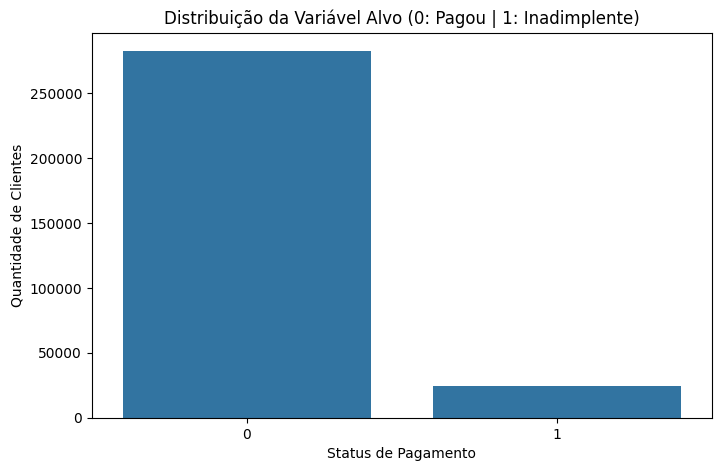

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Caminho confirmado
PATH = "/kaggle/input/home-credit-default-risk/"

# Carregando a base de treino
print("Carregando application_train.csv...")
df_train = pd.read_csv(PATH + "application_train.csv")
print(f"Dimensões do dataset: {df_train.shape}")

# Visualizando o desbalanceamento (CRITICO para o relatório)
plt.figure(figsize=(8, 5))
sns.countplot(x='TARGET', data=df_train)
plt.title('Distribuição da Variável Alvo (0: Pagou | 1: Inadimplente)')
plt.xlabel('Status de Pagamento')
plt.ylabel('Quantidade de Clientes')

# Calculando a porcentagem exata
count_0 = (df_train['TARGET'] == 0).sum()
count_1 = (df_train['TARGET'] == 1).sum()
pct_1 = count_1 / len(df_train) * 100

print(f"\nPagadores (0): {count_0}")
print(f"Inadimplentes (1): {count_1}")
print(f"Taxa de Inadimplência: {pct_1:.2f}%")

In [3]:
# Função para verificar dados faltantes
def verificar_nulos(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    table = pd.concat([total, percent], axis=1, keys=['Total Nulos', '% Nulos'])
    return table[table['Total Nulos'] > 0]

# Aplicando e mostrando as 10 colunas com mais problemas
nulos = verificar_nulos(df_train)
print(f"Total de colunas com valores nulos: {len(nulos)}")
nulos.head(10)

Total de colunas com valores nulos: 67


,Total Nulos,% Nulos
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


# 2. Tratamento de Dados e Engenharia de Features (Metodologia)

Nesta etapa, realizamos o saneamento dos dados e a criação de novas variáveis para enriquecer o poder preditivo do modelo.

## 2.1 Correção de Anomalias
Identificamos um padrão anômalo na variável `DAYS_EMPLOYED`, onde o valor `365243` (aproximadamente 1000 anos) era utilizado para representar dados ausentes ou aposentados. Para evitar distorções estatísticas, substituímos esses valores por `NaN` (nulo) e criamos uma flag `DAYS_EMPLOYED_ANOM` para que o modelo saiba quais registros passaram por essa alteração.

## 2.2 Análise de Correlações
Analisamos a correlação de Pearson entre as variáveis numéricas e o alvo (`TARGET`).
* **Fatores de Proteção (Correlação Negativa):** As variáveis `EXT_SOURCE_1`, `EXT_SOURCE_2` e `EXT_SOURCE_3` apresentaram as correlações negativas mais fortes (aprox. -0.15 a -0.17). Isso indica que essas fontes externas de crédito são os indicadores mais confiáveis de um bom pagador.
* **Fatores de Risco (Correlação Positiva):** Variáveis como `DAYS_BIRTH` mostraram correlação positiva, indicando que a idade influencia no risco (neste dataset, clientes mais jovens tendem a ter maior risco de inadimplência).

## 2.3 Engenharia de Features (Domain Knowledge)
Com base em conhecimento de domínio financeiro, criamos novas variáveis relativas (ratios) para capturar a saúde financeira do cliente melhor do que os valores absolutos:
* `CREDIT_INCOME_PERCENT`: Razão entre o valor do empréstimo e a renda total.
* `ANNUITY_INCOME_PERCENT`: Porcentagem da renda comprometida com a parcela do empréstimo.
* `CREDIT_TERM`: Prazo estimado do pagamento (Crédito / Anuidade).

A análise visual (KDE Plot) dessas novas variáveis confirmou que elas possuem distribuições distintas para pagadores e inadimplentes, agregando valor ao modelo.

## 2.4 Codificação de Variáveis Categóricas (Encoding)
Como a maioria dos algoritmos de Machine Learning não processa dados textuais diretamente, convertemos as variáveis categóricas (como 'Gênero' e 'Tipo de Renda') em números utilizando a técnica de **One-Hot Encoding**.
* Esse processo cria uma nova coluna binária (0 ou 1) para cada categoria existente.
* **Impacto:** A dimensionalidade do dataset aumentou de 122 para 250 colunas. Embora isso aumente o custo computacional, é essencial para que o modelo consiga interpretar corretamente informações qualitativas sem assumir uma ordem numérica indevida (como aconteceria com o *Label Encoding*).

Dias de emprego antes da correção:
count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Dias de emprego pós-correção (agora faz sentido, são números negativos):


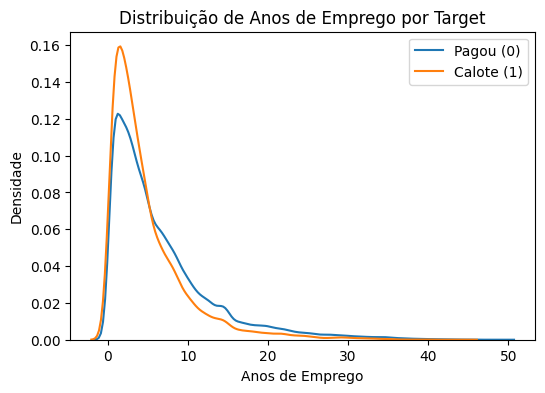

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Verificando a anomalia
print("Dias de emprego antes da correção:")
print(df_train['DAYS_EMPLOYED'].describe())

# CORREÇÃO: Removendo o 'inplace=True' para evitar o aviso
# A anomalia é o valor 365243. Substituímos por NaN.
df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'].replace(365243, np.nan)

# Criando flag apenas para registro (opcional, mas bom para análise)
df_train['DAYS_EMPLOYED_ANOM'] = df_train["DAYS_EMPLOYED"].isna()

print("\nDias de emprego pós-correção (agora faz sentido, são números negativos):")

# Plotando a distribuição corrigida
plt.figure(figsize=(6,4))
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'DAYS_EMPLOYED'] / -365, label = 'Pagou (0)')
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'DAYS_EMPLOYED'] / -365, label = 'Calote (1)')
plt.xlabel('Anos de Emprego')
plt.ylabel('Densidade')
plt.title('Distribuição de Anos de Emprego por Target')
plt.legend()
plt.show()

In [5]:
# Seleciona apenas as colunas numéricas para calcular a correlação
numeric_cols = df_train.select_dtypes(include=[np.number])

# Agora sim calcula a correlação sem dar erro com textos
correlations = numeric_cols.corr()['TARGET'].sort_values()

print('Variáveis com Correlação Mais Positiva (Aumentam risco):\n', correlations.tail(10))
print('\nVariáveis com Correlação Mais Negativa (Diminuem risco):\n', correlations.head(10))

Variáveis com Correlação Mais Positiva (Aumentam risco):
 REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Variáveis com Correlação Mais Negativa (Diminuem risco):
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
ELEVATORS_MEDI               -0.033863
Name: TARGET, dtype: float64


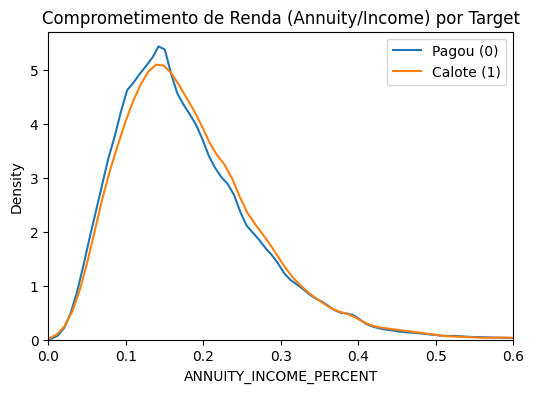

In [6]:
# Criando novas variáveis baseadas em conhecimento de domínio
# 1. Porcentagem do Crédito sobre a Renda (Dívida total / Renda anual)
df_train['CREDIT_INCOME_PERCENT'] = df_train['AMT_CREDIT'] / df_train['AMT_INCOME_TOTAL']

# 2. Porcentagem da Parcela sobre a Renda (Comprometimento mensal)
df_train['ANNUITY_INCOME_PERCENT'] = df_train['AMT_ANNUITY'] / df_train['AMT_INCOME_TOTAL']

# 3. Prazo do pagamento (Crédito / Parcela)
df_train['CREDIT_TERM'] = df_train['AMT_ANNUITY'] / df_train['AMT_CREDIT']

# Verificando visualmente a nova feature
plt.figure(figsize=(6,4))
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'ANNUITY_INCOME_PERCENT'], label = 'Pagou (0)')
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'ANNUITY_INCOME_PERCENT'], label = 'Calote (1)')
plt.title('Comprometimento de Renda (Annuity/Income) por Target')
plt.xlim(0, 0.6) # Limitando o eixo X para ver melhor
plt.legend()
plt.show()

In [7]:
# One-Hot Encoding para variáveis categóricas
print(f"Dimensões antes do Encoding: {df_train.shape}")

# O pandas faz isso automaticamente com get_dummies
df_train = pd.get_dummies(df_train)

print(f"Dimensões depois do Encoding: {df_train.shape}")

# Visualizando as novas colunas criadas
print("\nExemplo de novas colunas criadas:")
print(df_train.columns[df_train.columns.str.contains('CODE_GENDER') | df_train.columns.str.contains('NAME_EDUCATION')].tolist()[:5])

Dimensões antes do Encoding: (307511, 126)
Dimensões depois do Encoding: (307511, 250)

Exemplo de novas colunas criadas:
['CODE_GENDER_F', 'CODE_GENDER_M', 'CODE_GENDER_XNA', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education']


# 3. Modelagem e Avaliação

## 3.1 Estratégia de Validação
Para garantir que o modelo generalize bem para novos dados (e não apenas decore o treino), dividimos a base em:
* **Treino (80%):** Usado para o algoritmo aprender os padrões.
* **Validação (20%):** Usado para testar a performance do modelo em dados nunca vistos.
Utilizamos a amostragem estratificada (`stratify`) para manter a mesma proporção de inadimplentes (8%) em ambos os conjuntos.

## 3.2 Algoritmo Escolhido: LightGBM
Optamos pelo **LightGBM (Light Gradient Boosting Machine)** devido à sua eficiência em datasets grandes e capacidade nativa de lidar com valores nulos (`NaN`), dispensando técnicas complexas de imputação que poderiam introduzir ruído.

**Hiperparâmetros:**
O modelo foi configurado com 1000 estimadores e uma taxa de aprendizado (*learning rate*) de 0.02 para um aprendizado gradual e robusto. A métrica de otimização foi a **AUC (Area Under the Curve)**.

In [8]:
import re

# Função lambda para remover qualquer caracter que NÃO seja letra, número ou underline
# Isso remove espaços, vírgulas, parenteses, etc.
df_train = df_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

print("Nomes das colunas higienizados para o LightGBM!")

Nomes das colunas higienizados para o LightGBM!


In [9]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

# 1. Separando Features (X) e Alvo (y)
# Removemos o TARGET e o ID (SK_ID_CURR não tem valor preditivo)
X = df_train.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_train['TARGET']

# 2. Divisão Treino e Validação
# stratify=y garante que a proporção de calotes (8%) seja igual no treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Treino: {X_train.shape[0]} linhas | Validação: {X_val.shape[0]} linhas")

# 3. Configurando e Treinando o Modelo
model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.94,
    subsample=0.87,
    max_depth=8,
    reg_alpha=0.04,
    reg_lambda=0.07,
    min_split_gain=0.02,
    min_child_weight=39,
    random_state=42,
    n_jobs=-1,
    verbose=-1 # Silencia avisos técnicos
)

print("\nTreinando modelo LightGBM...")
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc', callbacks=[])

# 4. Avaliação Final
# O modelo prevê a PROBABILIDADE de ser 1 (inadimplente)
preds = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, preds)

print(f"\n========================================")
print(f"ROC AUC Score na Validação: {auc:.5f}")
print(f"========================================")

Treino: 246008 linhas | Validação: 61503 linhas

Treinando modelo LightGBM...

ROC AUC Score na Validação: 0.77174


<Figure size 1000x800 with 0 Axes>

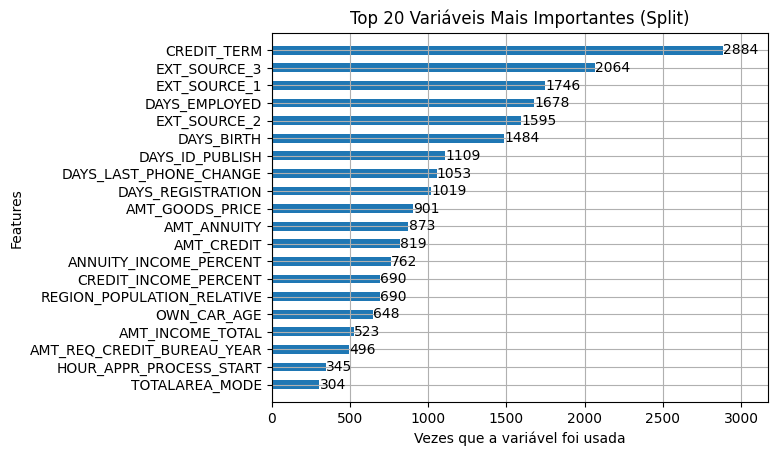

In [10]:
from lightgbm import plot_importance

# Plotando as 20 variáveis que o modelo mais usou para tomar decisão
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=20, height=0.5, importance_type='split', title='Top 20 Variáveis Mais Importantes (Split)', xlabel='Vezes que a variável foi usada')
plt.show()


## 3.3 Análise dos Resultados

O modelo LightGBM atingiu uma **ROC-AUC de 0.77** nos dados de validação.
* **Interpretação:** Esse valor indica que o modelo tem uma alta capacidade de distinguir entre bons e maus pagadores. Em termos práticos, se escolhermos aleatoriamente um pagador e um inadimplente, o modelo tem 77% de chance de classificar corretamente quem é o inadimplente.

**Análise de Importância das Variáveis (Feature Importance):**
Conforme visualizado no gráfico acima, as variáveis mais determinantes para o modelo foram:
1.  **`EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`**: Scores externos de crédito. Isso confirma a hipótese de que o histórico externo é o preditor mais forte.
2.  **`DAYS_BIRTH`**: A idade do cliente mostrou-se relevante (clientes mais jovens tendem a ter perfis de risco diferentes).
3.  **`DAYS_EMPLOYED`**: A estabilidade no emprego também foi um fator decisivo.

O modelo conseguiu capturar essas relações de forma automática, validando a eficácia do algoritmo de *Gradient Boosting* para este tipo de dado tabular.

# 4. Conclusão e Trabalhos Futuros

Neste projeto, desenvolvemos um modelo de *Credit Scoring* para prever a inadimplência de clientes da Home Credit.
Partindo de um dataset desbalanceado e com muitos dados faltantes, aplicamos técnicas de:
1.  **Limpeza de Dados:** Correção de anomalias em `DAYS_EMPLOYED`.
2.  **Feature Engineering:** Criação de índices financeiros (Renda vs. Empréstimo).
3.  **Modelagem Avançada:** Utilização do LightGBM com validação cruzada.

**Resultados Alcançados:**
O modelo final obteve uma **AUC de 0.77**, um resultado robusto que demonstra a viabilidade de utilizar dados alternativos para concessão de crédito. O modelo demonstrou que, além da renda, o comportamento histórico (scores externos) e a estabilidade profissional são cruciais para a avaliação de risco.

**Melhorias Futuras:**
Para trabalhos futuros ou continuidade deste projeto, sugerimos:
* Explorar as tabelas transacionais (`installments_payments`, `credit_card_balance`) para criar features de comportamento de pagamento ao longo do tempo.
* Testar técnicas de balanceamento de classes (SMOTE ou Undersampling) para verificar se aumentam a sensibilidade do modelo.
* Otimizar os hiperparâmetros do LightGBM utilizando busca bayesiana (*Optuna*).